# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [ ]:
# Update the PATH to include the user installation directory. 
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

# Restart the Kernel before you move on to the next step.

#### Important: Restart the Kernel before you move on to the next step.

In [ ]:
# Install requirements
!python -m pip install -r requirements.txt

In [38]:
# If using MacOS, you may need to install the following to enable the mps acceleration
!python -m pip uninstall torch torchvision -y
!python -m pip install torch==2.0.1 torchvision==0.15.2


  Using cached torchvision-0.15.2-cp39-cp39-macosx_10_9_x86_64.whl.metadata (11 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.4/143.4 MB 2.9 MB/s eta 0:00:0000:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 4.1 MB/s eta 0:00:0000:0100:01


## Imports

In [2]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

from torchvision import datasets
from torch.utils.data import DataLoader

import time
import matplotlib.pyplot as plt

In [15]:
# Check torch version and CUDA status if GPU is enabled.
print(torch.__version__)
print(f'CUDA: {torch.cuda.is_available()}') # Should return True when GPU is enabled.

# Check if MPS is available
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

2.0.1
CUDA: False
tensor([1.], device='mps:0')


## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

Sample image type: <class 'PIL.Image.Image'>
Sample image size: (28, 28)
Sample image mode: L
Sample image shape as numpy array: (28, 28)


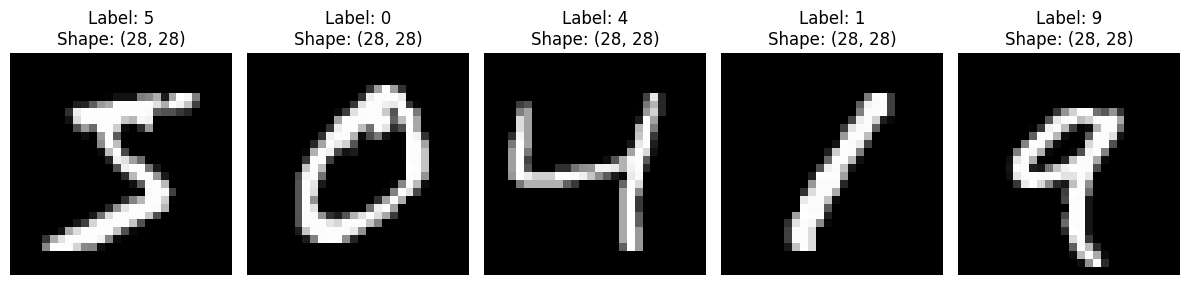

In [4]:
# Explore the dataset before defining the transformations

# Load the dataset without transorms
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=None)

def show_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(12, 3))
    for i in range(num_images):
        img, label = dataset[i]
        
        # Convert PIL Image to numpy array
        img = np.array(img)
        
        # Determine the shape and choose colormap
        if img.ndim == 2 or (img.ndim == 3 and img.shape[2] == 1):
            # Grayscale image
            img = img.squeeze()
            cmap = 'gray'
        elif img.ndim == 3 and img.shape[2] == 3:
            # Color image
            cmap = None
        else:
            raise ValueError(f"Unexpected image shape: {img.shape}")
        
        axes[i].imshow(img, cmap=cmap)
        axes[i].axis('off')
        axes[i].set_title(f"Label: {label}\nShape: {img.shape}")
    
    plt.tight_layout()
    plt.show()

# Display image shape before showing images
sample_img, _ = train_dataset[0]
print(f"Sample image type: {type(sample_img)}")
print(f"Sample image size: {sample_img.size}")
print(f"Sample image mode: {sample_img.mode}")

# Convert to numpy array to show shape
sample_img_array = np.array(sample_img)
print(f"Sample image shape as numpy array: {sample_img_array.shape}")

# Show images
show_images(train_dataset)

In [5]:
# Calculate mean and std for normalization for single channel images (gray scale)
train_data = train_dataset.data.float() / 255  # Convert to float and scale to [0, 1]
td_mean = train_data.mean()
td_std = train_data.std()
print(f"Mean: {td_mean:.4f}, Std: {td_std:.4f}")

Mean: 0.1307, Std: 0.3081


In [6]:
# Define transforms
def define_transforms():
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomRotation(10),
        transforms.Normalize((td_mean.item(),) , (td_std.item(),))
    ])

# Create training set and define training dataloader
def create_train_loader(batch_size=64):
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=define_transforms())
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    return train_loader

# Create test set and define test dataloader
def create_test_loader(batch_size=64):
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=define_transforms())
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return test_loader

train_loader = create_train_loader()
test_loader = create_test_loader()

In [31]:
for images, labels in train_loader:
    print("Batch shape:", images.shape)
    print("Sample image shape:", images[0].shape)
    break  # Just print the first batch and exit the loop

Batch shape: torch.Size([64, 1, 28, 28])
Sample image shape: torch.Size([1, 28, 28])


## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

I have defined the 3 transformations:
1) Converts PIL images to PyTorch tensors and scales pixel values to [0,1], ensuirng all input features are on a similar scale.
2) Applies trandom rotations of up to +- 10 degrees, enhancing model robustness to sligh orientation variations in handwritten digits.
3) Normalizes the tensor using the calculated mean and standard deviation of the training data, potentially accelerating the training process and improving model generalization.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [28]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

5


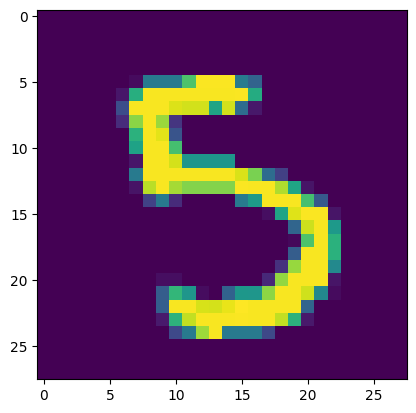

7


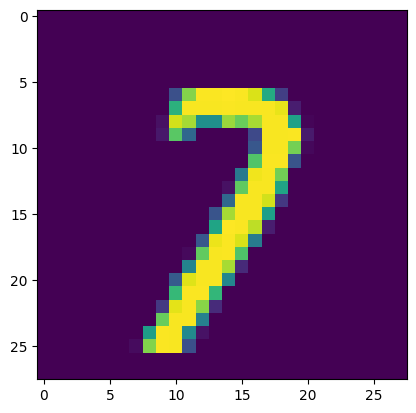

8


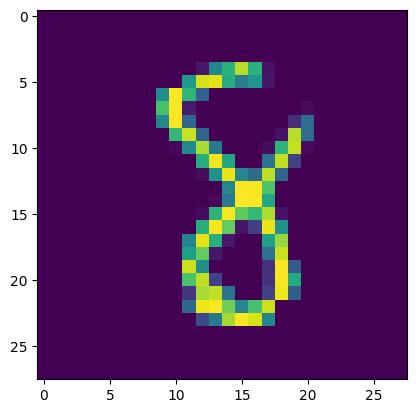

3


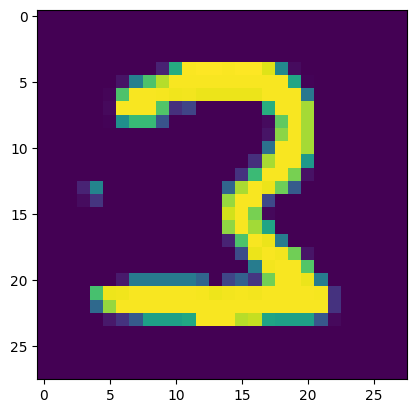

6


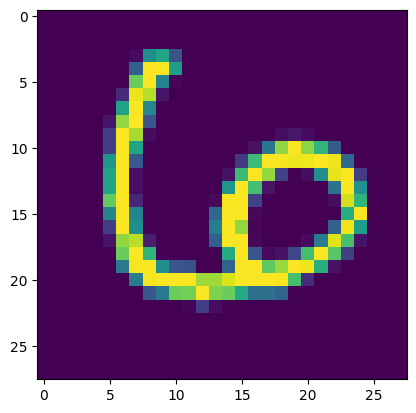

In [30]:
# Explore data
show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [36]:
# Build a feed-forward network with two hidden layers and a forward method
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        self.dropout = nn.Dropout(0.2) 

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))     # LogSoftmax is more effiecient when combined with NLLLoss()
        return F.log_softmax(x, dim=1)


Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [37]:
model = Model()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [10]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, epochs=5, patience=5):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'mps' if  torch.backends.mps.is_available() else 'cpu')
    model.to(device)

    start = time.time()
    steps = 0
    running_loss = 0
    print_every = len(train_loader) // 2
    train_losses, valid_losses, valid_accuracies = [], [], []

    best_loss = float('inf')
    no_improve = 0
    best_model = None

    print(f'Start training on {device}')
    for epoch in range(epochs):
        model.train()
        for inputs, labels in train_loader:
            steps += 1
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            logps = model.forward(inputs)
            loss = criterion(logps, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # Validate the model
            if steps % print_every == 0:
                valid_loss = 0
                accuracy = 0
                model.eval()
                with torch.no_grad():
                    for inputs, labels in valid_loader:
                        inputs, labels = inputs.to(device), labels.to(device)
                        logps = model.forward(inputs)
                        batch_loss = criterion(logps, labels)
                        valid_loss += batch_loss.item()

                        # Calculate accuracy
                        ps = torch.exp(logps)
                        top_p, top_class = ps.topk(1, dim=1)
                        equals = top_class == labels.view(*top_class.shape)
                        accuracy += torch.mean(equals.float()).item()

                train_loss = running_loss / print_every
                valid_loss = valid_loss / len(valid_loader)
                accuracy = accuracy / len(valid_loader)

                train_losses.append(train_loss)
                valid_losses.append(valid_loss)
                valid_accuracies.append(accuracy)

                print(f"Epoch {epoch+1}/{epochs}.. "
                        f"Time: {(time.time()-start)/60:.2f} minutes.."
                        f"Train loss: {train_loss:.3f}.. "
                        f"Validation loss: {valid_loss:.3f}.. "
                        f"Validation accuracy: {accuracy:3f}")
                running_loss = 0
                model.train()

                # Early stopping
                if valid_loss < best_loss:
                    best_loss = valid_loss
                    no_improve = 0
                    best_model = model.state_dict()
                else:
                    no_improve += 1
                    if no_improve == patience:
                        print(f'Early stopping at epoch {epoch+1}')
                        model.load_state_dict(best_model)
                        return train_losses, valid_losses, valid_accuracies
            
    print(f"Total time: {(time.time()-start)/60:.2f} minutes")
    return train_losses, valid_losses, valid_accuracies

In [38]:
# Train the model
train_losses, valid_losses, valid_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=5)

Start training on mps
Epoch 1/5.. Time: 0.44 minutes..Train loss: 0.668.. Validation loss: 0.371.. Validation accuracy: 0.8567874203821656
Epoch 1/5.. Time: 0.84 minutes..Train loss: 0.402.. Validation loss: 0.334.. Validation accuracy: 0.8654458598726115
Epoch 2/5.. Time: 1.24 minutes..Train loss: 0.366.. Validation loss: 0.322.. Validation accuracy: 0.8703224522292994
Epoch 2/5.. Time: 1.64 minutes..Train loss: 0.349.. Validation loss: 0.313.. Validation accuracy: 0.8705214968152867
Epoch 3/5.. Time: 2.03 minutes..Train loss: 0.343.. Validation loss: 0.306.. Validation accuracy: 0.8740047770700637
Epoch 3/5.. Time: 2.43 minutes..Train loss: 0.330.. Validation loss: 0.309.. Validation accuracy: 0.8728105095541401
Epoch 4/5.. Time: 2.83 minutes..Train loss: 0.325.. Validation loss: 0.299.. Validation accuracy: 0.8751990445859873
Epoch 4/5.. Time: 3.22 minutes..Train loss: 0.324.. Validation loss: 0.300.. Validation accuracy: 0.8745023885350318
Epoch 5/5.. Time: 3.61 minutes..Train loss

Plot the training loss (and validation loss/accuracy, if recorded).

In [14]:
import matplotlib.pyplot as plt

def plot_training_progress(train_losses, valid_losses, valid_accuracies):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss')
    plt.plot(valid_losses, label='Validation loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(valid_accuracies, label='Validation accuracy')
    plt.xlabel('Steps')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

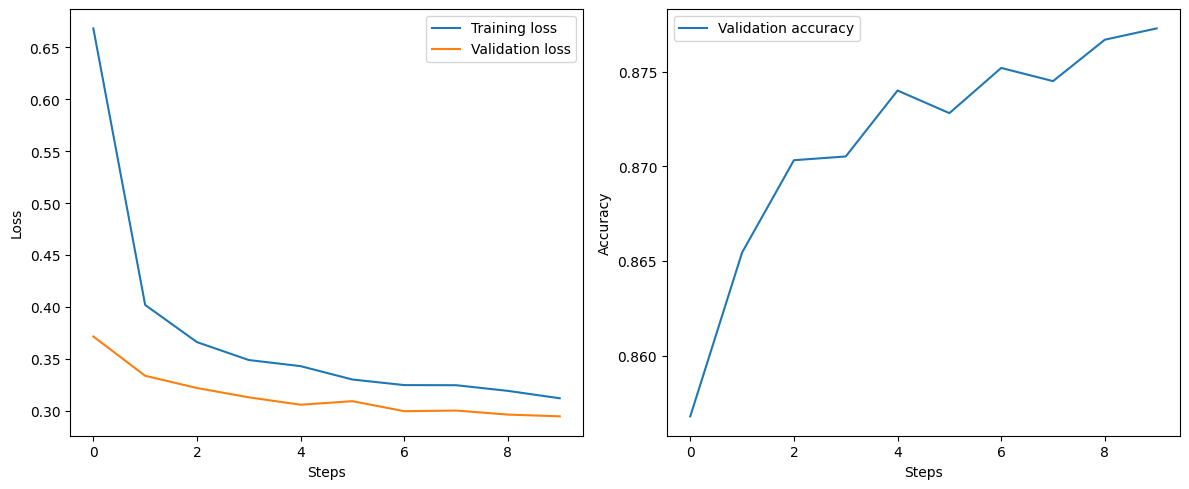

In [39]:
plot_training_progress(train_losses, valid_losses, valid_accuracies)

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [16]:
def test_model(model, test_loader):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'mps' if  torch.backends.mps.is_available() else 'cpu')
    model.to(device)

    start = time.time()
    test_loss = 0
    accuracy = 0
    model.eval()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs)
            batch_loss = criterion(logps, labels)
            test_loss += batch_loss.item()

            # Calculate accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.float()).item()

    test_loss = test_loss / len(test_loader)
    accuracy = accuracy / len(test_loader)
    print(f"Time: {(time.time()-start)/60:.2f} minutes.."
        f"Test loss: {test_loss:.3f}.. "
        f"Test accuracy: {accuracy:.3f}")
    return test_loss, accuracy


In [40]:
# Test the model
test_loss, test_accuracy = test_model(model, test_loader)

Time: 0.08 minutes..Test loss: 0.293.. Test accuracy: 0.877


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [18]:
class Model_v2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = self.dropout1(x)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        return F.log_softmax(x, dim=1)


model_v2 = Model_v2()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model_v2.parameters(), lr=0.001, weight_decay=1e-5)

train_losses_v2, valid_losses_v2, valid_accuracies_v2 = train_model(model_v2, train_loader, test_loader, criterion, optimizer, epochs=5, patience=5)


Start training on mps
Epoch 1/5.. Time: 0.41 minutes..Train loss: 0.572.. Validation loss: 0.126.. Validation accuracy: 0.961485
Epoch 1/5.. Time: 0.81 minutes..Train loss: 0.180.. Validation loss: 0.089.. Validation accuracy: 0.973129
Epoch 2/5.. Time: 1.21 minutes..Train loss: 0.134.. Validation loss: 0.064.. Validation accuracy: 0.979797
Epoch 2/5.. Time: 1.62 minutes..Train loss: 0.115.. Validation loss: 0.055.. Validation accuracy: 0.982484
Epoch 3/5.. Time: 2.02 minutes..Train loss: 0.099.. Validation loss: 0.054.. Validation accuracy: 0.982882
Epoch 3/5.. Time: 2.42 minutes..Train loss: 0.097.. Validation loss: 0.047.. Validation accuracy: 0.984674
Epoch 4/5.. Time: 2.85 minutes..Train loss: 0.085.. Validation loss: 0.046.. Validation accuracy: 0.985271
Epoch 4/5.. Time: 3.31 minutes..Train loss: 0.083.. Validation loss: 0.044.. Validation accuracy: 0.985370
Epoch 5/5.. Time: 3.72 minutes..Train loss: 0.076.. Validation loss: 0.041.. Validation accuracy: 0.985967
Epoch 5/5.. Tim

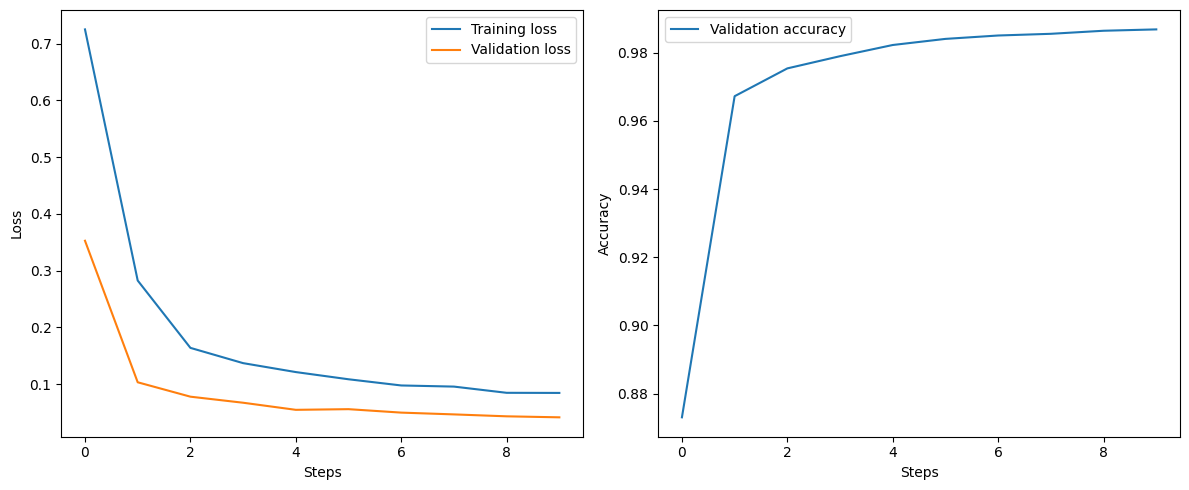

Time: 0.07 minutes..Test loss: 0.042.. Test accuracy: 0.986


In [17]:
plot_training_progress(train_losses_v2, valid_losses_v2, valid_accuracies_v2)

test_loss_v2, test_accuracy_v2 = test_model(model_v2, test_loader)

## Saving your model
Using `torch.save`, save your model for future loading.

In [35]:
checkpoint = {
    'epoch': 5,
    'patience': 5,
    'criterion': criterion,
    'model': model_v2,
    'hyperparameters': {
        'lr': 0.001,
        'weight_decay': 1e-5,
        'batch_size': 64
    },
    'optimizer_state_dict': optimizer.state_dict(),
    'model_state_dict': model_v2.state_dict(),
    'train_losses': train_losses_v2,
    'valid_losses': valid_losses_v2,
    'valid_accuracies': valid_accuracies_v2,
    'test_loss': test_loss_v2,
    'test_accuracy': test_accuracy_v2
}

def save_checkpoint(checkpoint, filename='mnist_model.pth'):
    torch.save(checkpoint, filename)
    print(f"Checkpoint saved to {filename}")

save_checkpoint(checkpoint)

Checkpoint saved to mnist_model.pth
